<h1> <i>Homework 3: Linear Regression and Regularization.</i> </h1>

<p>In this notebook I am using "CLV.xlsx" dataset to analyze <b>Customer lifetime value</b> by using linear regression and regularization methods. The dependent variable is <b>Customer lifetime value</b>. I will analyze the relationship between CLV and other variables in the dataset and also reveal the best model using different selection methods and data transformations.
    
<br>The steps for the analysis the following:
1. [Data Diagnostics](#part1)
2. [Descriptive analysis with visualizatio](#pandas)
3. [Model preparation](#select)
4. [Running and building the OLS model /statsmodels/ (model interpretation, test performance)](#stats)
5. [Regularization methods](#regs)   

<i> <u>importing all the needed libraries.</u></i>

In [40]:
import pandas as pd #pandas for data manipulation, transformation
import matplotlib.pyplot as plt #visualization
import seaborn as sns #visualization
import numpy as np #for scientific computations
import statsmodels.api as sm #statsmodels library
import warnings
from sklearn.metrics import mean_squared_error # OLS mean squared error
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV,ElasticNet, ElasticNetCV

warnings.filterwarnings('ignore', category=UserWarning)

In [41]:
data=pd.read_excel("CLV.xlsx")
# data.head()
# data.info()

 <h2>1.Data Diagnostics </h2> <a name="part1"></a>

<u>Geting insightful information of the features by <br> </u>
1.Identifying how many observations and features are presented, how many of them are numeric and categorical<br>


In [42]:
# Number of observations and features
num_observations, num_features = data.shape

# Identifying numeric and categorical features
numeric_features = data.select_dtypes(include=['number']).columns
categorical_features = data.select_dtypes(exclude=['number']).columns

print(f"Number of observations: {num_observations}")
print(f"Number of features: {num_features}")
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

Number of observations: 9134
Number of features: 24
Numeric features: 8
Categorical features: 16


2.Getting main statistics of the numeric features 

In [43]:
data[numeric_features].describe()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


3.How many observations have not available values<br>

In [44]:
print("Missing values:", data.isna().sum().sum())

Missing values: 0


4.Checking if there are duplicated observation <br>

In [45]:
print("Duplicates:", data.duplicated().sum()) 

Duplicates: 0



5.Removing "Customer"and "Effective_To_Date" columns from the dataset <br>

In [46]:
columns_to_remove = ["Customer", "Effective_To_Date"]
data = data.drop(columns=columns_to_remove)

 <h2>2.Descriptive analysis with visualization </h2> <a name="pandas"></a>

1.Plotting the Customer Life Time value distribution<br>

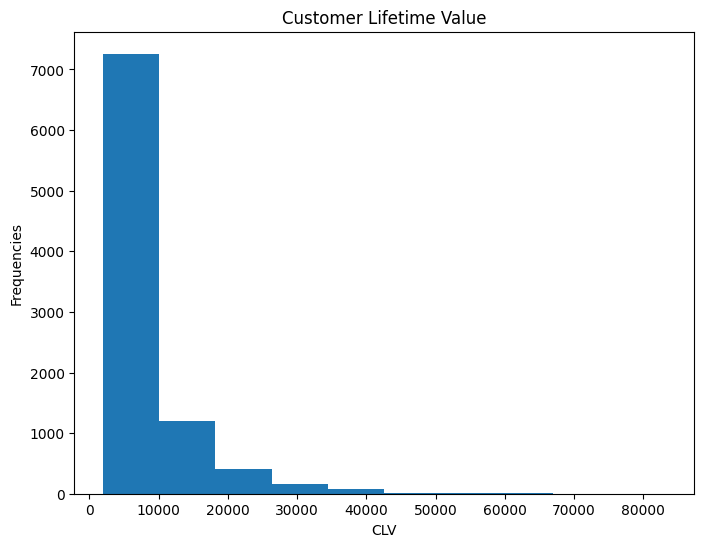

In [47]:
plt.figure(figsize=(8,6)) #making the graph bigger
plt.hist(data.Customer_Lifetime_Value)
plt.title("Customer Lifetime Value") #giving a title to the graph
plt.ylabel("Frequencies")#giving title to y axis
plt.xlabel("CLV")#giving title to x axis
plt.show()#showing the plot

This shows right-skewed distribution, which indicates that the majority of the CLV values are clustered toward the lower end of the scale. Since we have extreme values in the right side, when predicting CLV it would have been better to use log-linear model rather than a regular linear model. The intuition behind this approach is that for smaller values log function has less effect while for large values it has considerably decreasing effect, as a result we would get more consistent and somewhat normalized values.

2.Plotting a boxplot of CVL for Emploment status, does the CVL differ between subcategories?  <br>

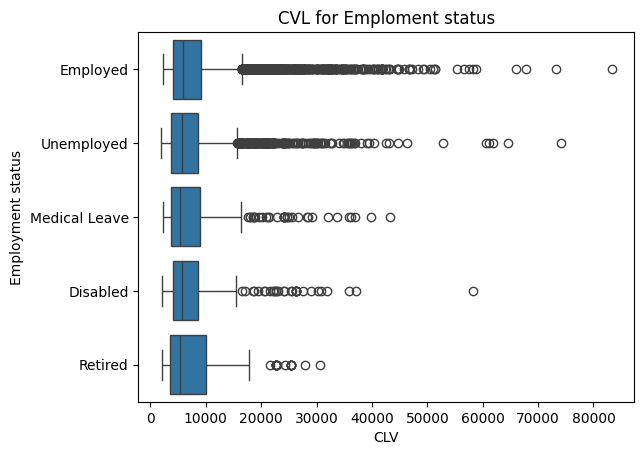

In [48]:
sns.boxplot(y=data.EmploymentStatus,x=data.Customer_Lifetime_Value)
plt.ylabel("Employment status")#giving title to y axis
plt.xlabel("CLV")
plt.title("CVL for Emploment status")
plt.show()

While the median for all subcategories is more or less the same, the box for the retired category is wider indicating greater variability. For retired category we observe the longest whiskers hence the range of CLV values for retired category is larger. We observe lots of outliers for the first two categories. Overall all boxplots show right skewed dist. To sum up, there might be some subtle differences, but the shape of the dist and median for categories are similar, making categories quite similar to one another.

3.Showing the relationship between CLV and Income<br>

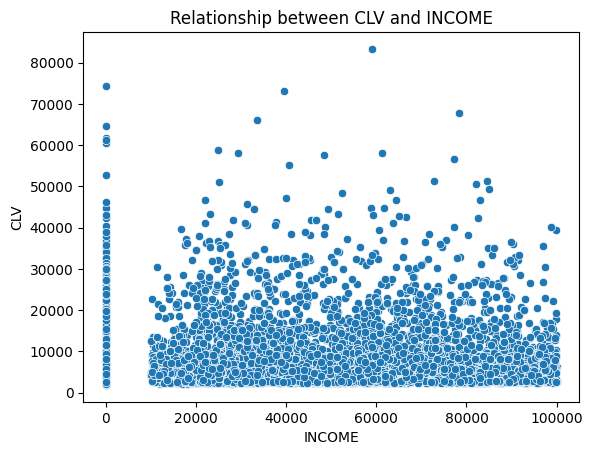

In [49]:
sns.scatterplot(data, x=data.Income,y=data.Customer_Lifetime_Value)
plt.xlabel("INCOME")
plt.ylabel("CLV")
plt.title("Relationship between CLV and INCOME")
plt.show()

 The small gap in the scatterplot might be indicate that there could be a clear division between customers with lower income and those with higher income in terms of CLV. It's controversial that customers with 0 income have high CLV. Customers with higher income tend to have a broader range of CLV values, with some customers having CLV exceeding 40k. However, there are also customers with higher income levels who have CLV values in the lower range.

4.Checking the multicollinearity between the features<br>

In [50]:
data_numeric = data[numeric_features]
data_numeric.corr()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
Customer_Lifetime_Value,1.000000,0.024366,0.396262,0.011517,0.009418,-0.036343,0.021955,0.226451
Income,0.024366,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
Monthly_Premium_Auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
Months_Since_Last_Claim,0.011517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
Months_Since_Policy_Inception,0.009418,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
Number_of_Open_Complaints,-0.036343,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
Number_of_Policies,0.021955,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
Total_Claim_Amount,0.226451,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


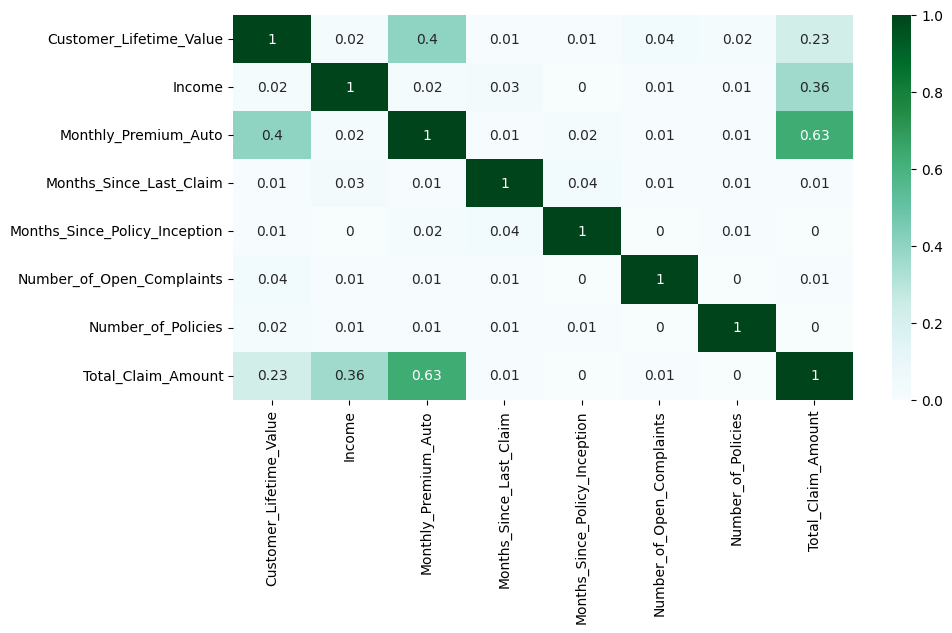

In [51]:
plt.figure(figsize=(10,5))
sns.heatmap(data_numeric.corr().abs().round(2),annot=True, cmap = "BuGn")
plt.show()

visualizing correlation heatmap to see any correlations above or equal to 75% in absolute values, if so, I will exclude them.

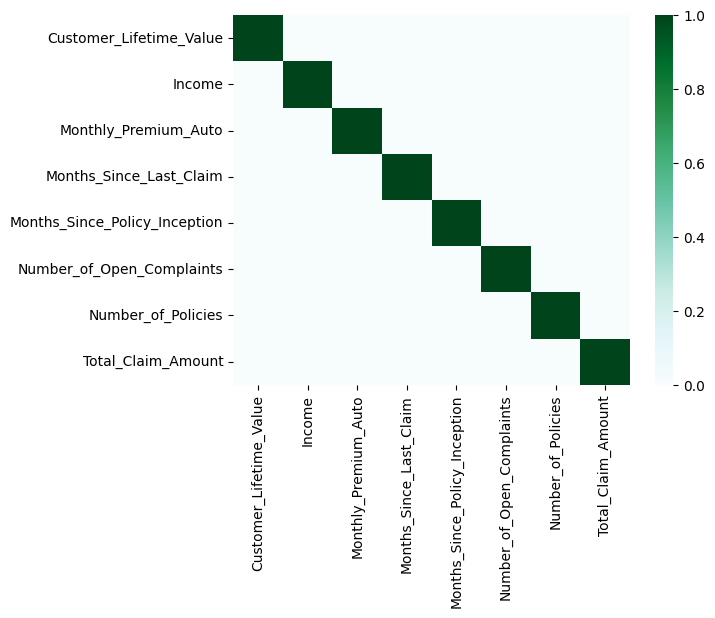

In [52]:
sns.heatmap(data_numeric.corr().abs()>=0.75, cmap = "BuGn")
plt.show()

This shows that there are no features that are too correlated which can be source of multicolinearity. The diag. is displayed since each element is correlated with itself.

5.Using sns.pairplot function to plot the relationship between variables <br>

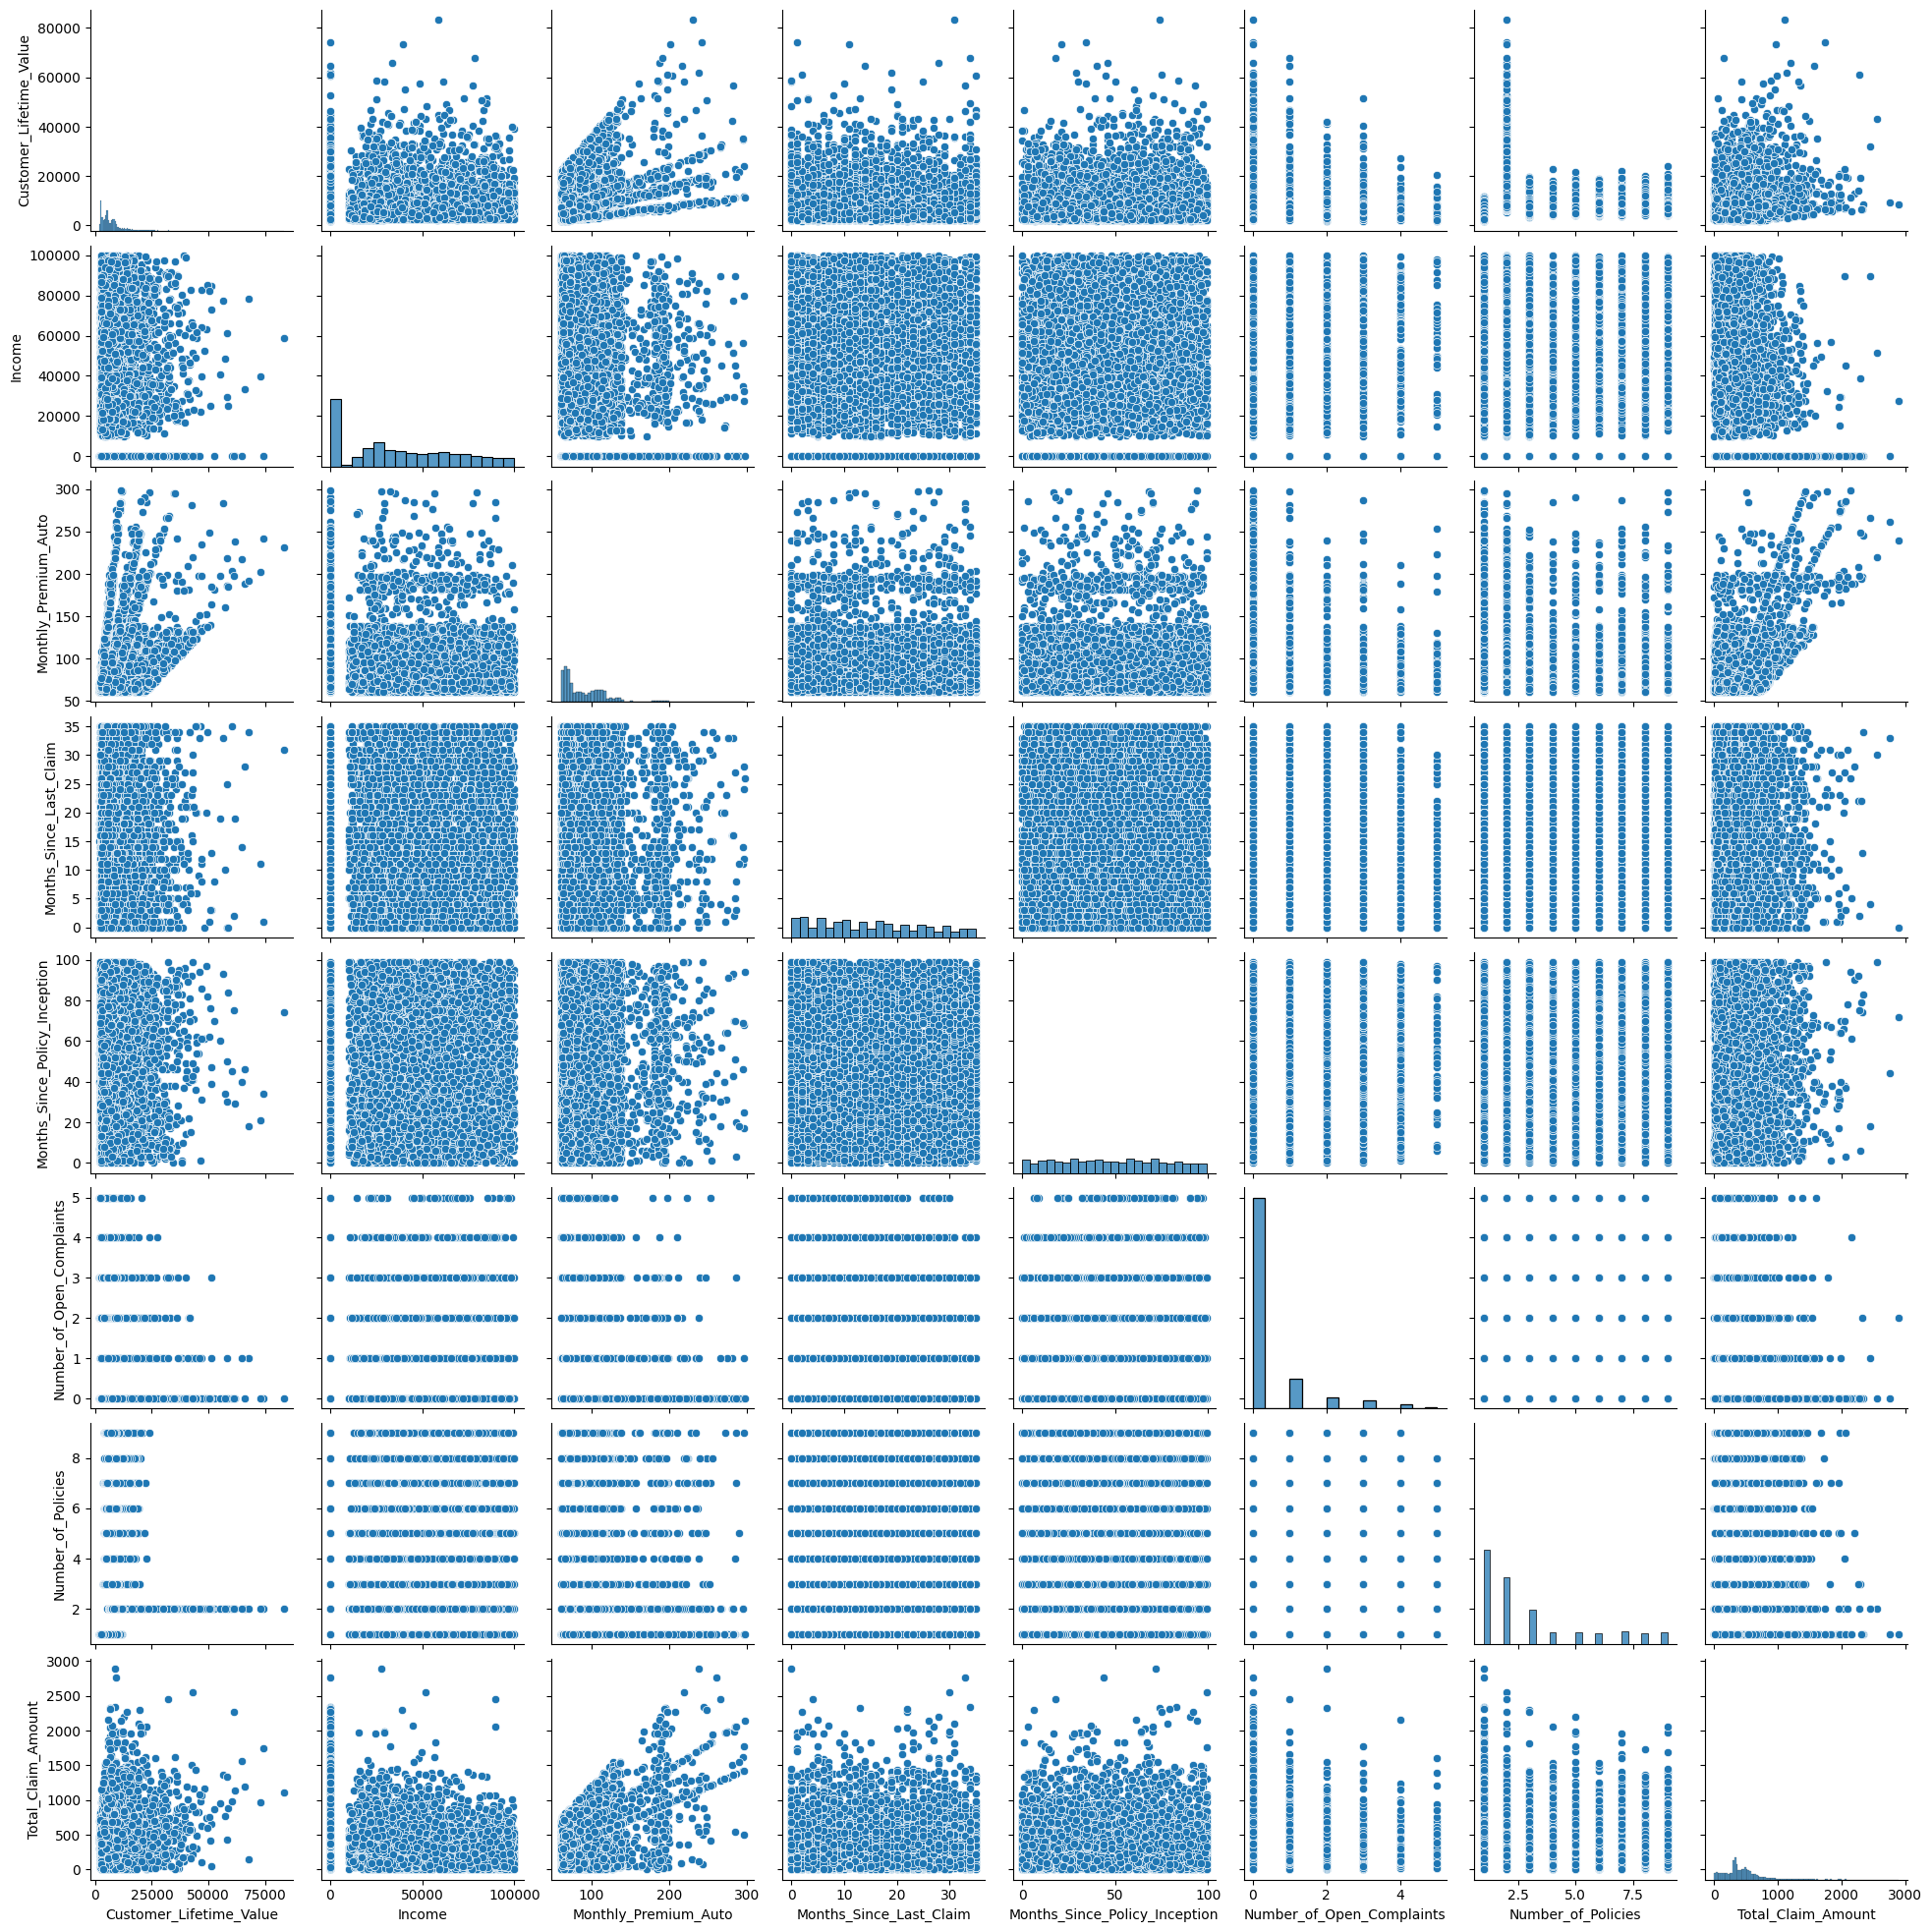

In [53]:
sns.pairplot(data)

As already mentioned above, there is no too strong obvious linearity between any of two variables. Still we see that they are not very random too. I think dropping any factors is not good decision here since we've seen that there are not extreme correlations but some kind of normalization would be good, since on y axis we see very different scales from variable to variable (for e.g. Total_claim_amount is in thousands, while num of policies is1,2,3...8). Also, there are some cases where we see some patterns(like regular grid, some patterns particular to count data) between two variables, this might be a sign that using some other model rather than linear would be better.

<h1> 3. Model preparation for OLS  </h1> <a name="select"> </a>

1.For the indendent variables preparing categorical ones for the model, keeping "Number_of_Policies","Total_Claim_Amount", "Number_of_Open_Complaints","EmploymentStatus","Coverage","Vehicle_Class" features <br>

In [54]:
selected_features = ['Customer_Lifetime_Value', "Number_of_Policies", "Total_Claim_Amount", "Number_of_Open_Complaints", "EmploymentStatus", "Coverage", "Vehicle_Class"]
data_ols=data[selected_features]

# separate the data that'll be used in our model into numeric and categorical
data_ols_categorical = data_ols.select_dtypes(exclude=['number'])
data_ols_numeric = data_ols.select_dtypes(include=['number'])

# for categorical vars, create dummies and combine them with numeric data into one df
data_ols = pd.concat((data_ols_numeric, pd.get_dummies(data_ols_categorical, drop_first=True)), axis=1)

2.Defining dependent (CLV) and independent variables <br>

In [55]:
Y = data_ols.Customer_Lifetime_Value
X = data_ols.drop(["Customer_Lifetime_Value"],axis=1)

3.Splitting the data into train and test sets <br>

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

<h1> 4. Running and building the OLS model /statsmodels/ (interpretation,test performance) </h1> <a name="stats">

1.Defining the constant and fitting trained data into the model <br>

In [57]:
# constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# the sm.OLS accepts only flot and int, but we have our dummies as boolean values, changing them to int(1,0)
for column in X_train.columns:
    if X_train[column].dtype == bool:
        X_train[column] = X_train[column].astype(int)
        
# fit    
results=sm.OLS(y_train, X_train).fit()

2.Getting the summary of the model <br>

In [58]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.159
Model:                                 OLS   Adj. R-squared:                  0.157
Method:                      Least Squares   F-statistic:                     92.06
Date:                     Sat, 23 Mar 2024   Prob (F-statistic):          1.44e-243
Time:                             20:12:09   Log-Likelihood:                -69574.
No. Observations:                     6850   AIC:                         1.392e+05
Df Residuals:                         6835   BIC:                         1.393e+05
Df Model:                               14                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           5688.4156    396.172     14.358      0.000    4911.795    6465.036
Number_of_Policies                73.9376     31.419      2.353      0.019      12.347     135.529
Total_Claim_Amount                 0.0615      0.372      0.165      0.869      -0.668       0.791
Number_of_Open_Complaints       -276.9562     82.645     -3.351      0.001    -438.966    -114.947
EmploymentStatus_Employed        228.5676    367.922      0.621      0.534    -492.673     949.809
EmploymentStatus_Medical Leave   144.6735    495.520      0.292      0.770    -826.699    1116.046
EmploymentStatus_Retired        -486.6401    551.131     -0.883      0.377   -1567.029     593.749
EmploymentStatus_Unemployed     -378.4796    386.844     -0.978      0.328   -1136.815     379.856
Coverage_Extended               1483.9425    172.270      8.614      0.000    1146.240    1821.645
Coverage_Premium                3269.9832    284.037     11.513      0.000    2713.182    3826.785
Vehicle_Class_Luxury Car         1.06e+04    620.787     17.079      0.000    9385.499    1.18e+04
Vehicle_Class_Luxury SUV        1.016e+04    601.287     16.891      0.000    8977.715    1.13e+04
Vehicle_Class_SUV               3778.0220    216.083     17.484      0.000    3354.431    4201.613
Vehicle_Class_Sports Car        3725.7868    350.637     10.626      0.000    3038.430    4413.143
Vehicle_Class_Two-Door Car       172.4828    197.348      0.874      0.382    -214.381     559.346
==============================================================================
Omnibus:                     4203.519   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46454.831
Skew:                           2.816   Prob(JB):                         0.00
Kurtosis:                      14.447   Cond. No.                     5.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

3.Interpretation: R-Squared value  <br>

R-squared value is 0.159, which means that approximately 15.9% of the variance in Customer Lifetime Value is explained by the independent variables included in the model.

4.Interpret the significant coefficient of a continous variable (5 points) <br>

Number_of_Policies - numeric - p = 0.019 < 0.05 => stat sign, coef = 73.9376 <br>
With one unit increase in num of policies(with each additional policy), ov average the clv increases by 73.9376.

5.Interpret the significant coefficient of a categorical variable (5 points) <br>

Coverage_Extended - categorical - p = 0 < 0.05 => stat sign, coef = 1483.9425	<br>
Compared to the referenced group(Basic), when the coverage is Extendes, on average cllv increases by 1483.9425	

6.Calculate the Mean Squared Error for train and test data, interpret the results (10 points) <br>

In [59]:
# Make predictions using the model
y_train_pred = results.predict(X_train)
y_test_pred = results.predict(X_test)

# Calculate Mean Squared Error for train and test data
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f'MSE for test data is: {mse_test}')
print(f'MSE for train data is: {mse_train}')

MSE for test data is: 42661820.26123189
MSE for train data is: 38867621.35723964


The MSE for the test data >  the MSE for the train data => model performs better on the data it was trained on compared to unseen data.

7.Checking the LINE(linearity, independence, normalaity, homoscedasticity) assumptions using residual visual analysis<br>

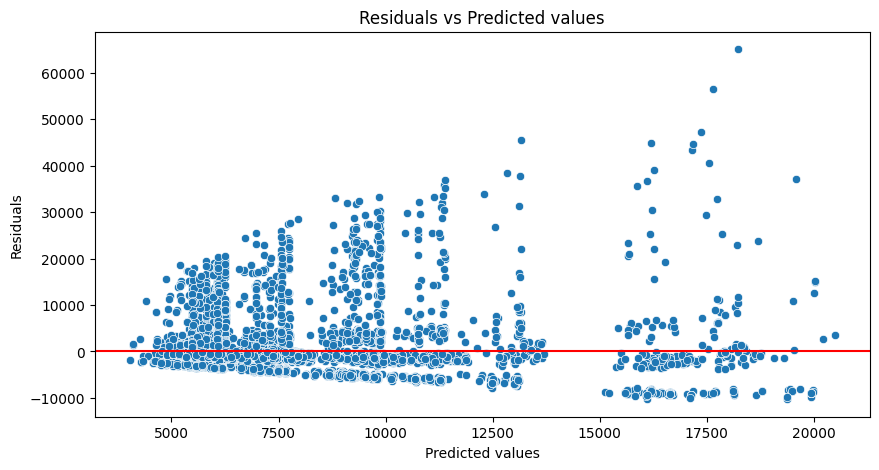

In [60]:
# residuals of the model
residuals=results.resid
predicted_values=results.predict()

# plot predicted values vs residuals
plt.figure(figsize=(10,5))
sns.scatterplot(x=predicted_values,y=residuals)
plt.axhline(y=0, c="red")
plt.title("Residuals vs Predicted values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

The residuals vs fitted values plot pattern is not totally random and we can see vertical groups of observations scattered together.

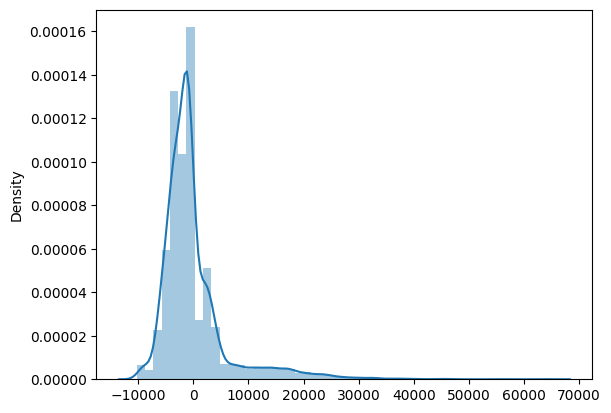

In [61]:
#Normality
#visual presentation- histogram
sns.distplot(residuals)
plt.show()

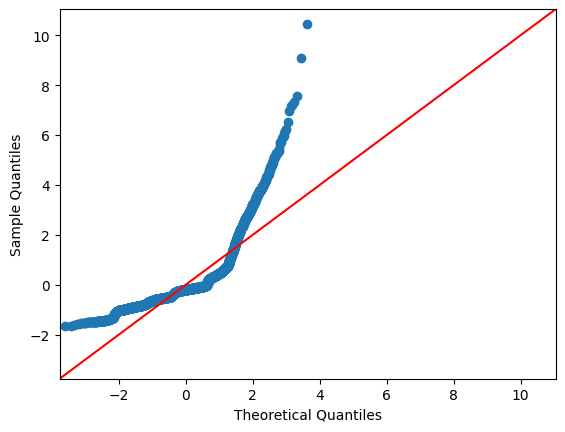

In [62]:
#QQ plot
qqplot(residuals,fit=True, line='45')
plt.show()

The residuals distribution plot shows that the distribution is not normal. QQ-plot shows a nonlinear pattern, since the (theoretica, sample quatile) points are not on the bisector.

8.Checking the LINE assumptions using residual diagnostic tests<br>

In [63]:
#Linearity 
#The null hypothesis assumes that the regression is correctly modelled as linear
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results)
print(list(zip(rnames, rainbow)))

[('fstat', 1.1110967657308075), ('p-value', 0.0010413083418026464)]


Linearity assumption is not held, since we have a small p-value.

In [64]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoscedasticity
bnames = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
breush = het_breuschpagan(residuals, results.model.exog)
print(list(zip(bnames, breush)))


[('Lagrange multiplier statistic', 397.1288508662355), ('p-value', 5.103848276889918e-76), ('f-value', 30.046156785297267), ('f p-value', 1.985459193888856e-78)]


The p-values are extremely close to zero indicating strong evidence against the null hypothesis of homoskedasticity. => reject Null

In [65]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
snames=['The test statistic', 'p-value']
shapirotest=shapiro(residuals)
print(list(zip(snames, shapirotest)))

[('The test statistic', 0.728191614151001), ('p-value', 0.0)]


The p-value is very close to zero, which is less than the typical significance level of 0.05. This indicates strong evidence against the null hypothesis that the data is normally distributed. => reject Null 

<h1>5.Regularization methods </h1><a name="regs"></a>

1.Preparing features for the model  <br>

In [66]:
data_numeric = data.select_dtypes(exclude=["object"])
data_object = data.select_dtypes(include=["object"])

data_full = pd.concat((data_numeric, pd.get_dummies(data_object, drop_first=True)), axis=1)
data_full= data_full.dropna()

2.Defining indipendent and dependent (CLV) variables <br>

In [67]:
#setting the varables
Y=data_full["Customer_Lifetime_Value"]
X=data_full.drop("Customer_Lifetime_Value", axis=1)

3.Splitting the data into train and test sets <br>

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

4.Setting the possible penalty ranges <br>

In [69]:
alphas = 10**np.linspace(10,-2,100)*0.5

5.Fitting the Lasso, Ridge and Elasic Net models on train data with cross validation = 10 to find the best alpha (lambda) <br>

In [70]:
# Create LassoCV, RidgeCV, and ElasticNetCV models with cross-validation
lassocv = LassoCV(alphas=alphas, cv=10)
ridgecv = RidgeCV(alphas=alphas, cv=10)
elasticnetcv = ElasticNetCV(alphas=alphas, cv=10)

# Fit the models on the training data
lassocv.fit(X_train, y_train)
ridgecv.fit(X_train, y_train)
elasticnetcv.fit(X_train, y_train)

# Get the best λ (alpha) values for Lasso, Ridge, and Elastic Net
best_alpha_lasso = lassocv.alpha_
best_alpha_ridge = ridgecv.alpha_
best_alpha_elasticnet = elasticnetcv.alpha_

6.Fitting the Lasso, Ridge and Elasic Net models on train data with the best α (lambda) <br>

In [71]:
# Create Lasso, Ridge, and Elastic Net models with the best alpha (lambda)
lasso_model = Lasso(alpha=best_alpha_lasso)
ridge_model = Ridge(alpha=best_alpha_ridge)
elasticnet_model = ElasticNet(alpha=best_alpha_elasticnet)

# Fit the models on the training data
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
elasticnet_model.fit(X_train, y_train)

ElasticNet(alpha=0.14240179342179024)

7.With α = 0 fitting the OLS model on train data<br>

In [72]:
ols_model = Ridge(alpha = 0) 
ols_model.fit(X_train, y_train)

Ridge(alpha=0)

8.Comparing the Mean Squared Error for test data for 4 models 

In [73]:
# Make predictions using the four models on the test data
lasso_pred = lasso_model.predict(X_test)
ridge_pred = ridge_model.predict(X_test)
elasticnet_pred = elasticnet_model.predict(X_test)
ols_pred = ols_model.predict(X_test)

# Calculate the MSE for each model
mse_lasso = mean_squared_error(y_test, lasso_pred)
mse_ridge = mean_squared_error(y_test, ridge_pred)
mse_elasticnet = mean_squared_error(y_test, elasticnet_pred)
mse_ols = mean_squared_error(y_test, ols_pred)

# Print the MSE for each model
print("MSE for Lasso: ", mse_lasso)
print("MSE for Ridge: ", mse_ridge)
print("MSE for Elastic Net: ", mse_elasticnet)
print("MSE for OLS (Ridge with alpha = 0): ", mse_ols)

#print(min(mse_lasso, mse_ridge, mse_elasticnet,mse_ols ))

MSE for Lasso:  42682312.31364211
MSE for Ridge:  42666753.37996336
MSE for Elastic Net:  42662984.921279185
MSE for OLS (Ridge with alpha = 0):  42811329.03568379


The MSE values represent the average squared differences between the actual values and the predicted values for each model on the test data.
Elastic Net has the least MSE which is an indicator of a better-performing model in terms of prediction accuracy.